# Example: Arbor plus .swc morphology file

Example utilizing the **`LFPykit`** module for predictions of extracellular potentials using 
the line source approximation implementation `LineSourcePotential` with a passive neuron model set up in Arbor (https://arbor.readthedocs.io, https://github.com/arbor-sim/arbor). 

The neuron receives sinusoid synaptic current input in one arbitrary chosen control volume (CV). 
Its morphology is defined in the file `single_cell.swc`

In [1]:
%matplotlib inline

In [2]:
## arbor may be installed using pip:
#!pip install git+https://github.com/espenhgn/arbor.git@isyn

In [3]:
## if running on mybinder or similar, uncomment and run the following to install LFPykit. 
## Then restart the kernel.
#!pip install ..

In [4]:
# import modules
import os
import numpy as np
import arbor
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
import scipy.stats as st
from LFPy.alias_method import alias_method
from LFPy.inputgenerators import get_activation_times_from_distribution

In [5]:
def create_polygon(x, y, d):
    """create a outline for each segment defined by 1D arrays `x`, `y`, `d`
    in x,y-plane which can be drawn using `plt.Polygon`
    
    Parameters
    ----------
    x: ndarray
    y: ndarray
    d: ndarray
    
    Returns
    -------
    x, y: nested list
    """
    dx = np.diff(x)
    dy = np.diff(y)
    theta = np.arctan2(dy, dx)

    xp = np.r_[(x + 0.5 * d * np.sin(theta)).ravel(), (x - 0.5 * d * np.sin(theta)).ravel()[::-1]]
    yp = np.r_[(y - 0.5 * d * np.cos(theta)).ravel(), (y + 0.5 * d * np.cos(theta)).ravel()[::-1]]
    
    return list(zip(xp, yp))


In [6]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw matplotlib colorbar without resizing the axes object
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

In [7]:
class BaseRecipe (arbor.recipe):
    def __init__(self, cell):
        super().__init__()
     
        self.the_cell = cell

        self.vprobe_id = (0, 0)
        self.iprobe_id = (0, 1)
        self.cprobe_id = (0, 2)

        self.the_props = arbor.neuron_cable_properties()
        self.the_cat = arbor.default_catalogue()
        self.the_props.register(self.the_cat)
       
    def num_cells(self):
        return 1

    def num_sources(self, gid):
        return 0

    def num_targets(self, gid):
        return 0

    def connections_on(self, gid):
        return []

    def event_generators(self, gid):
        return []
    
    def cell_kind(self, gid):
        return arbor.cell_kind.cable

    def cell_description(self, gid):
        return self.the_cell

    def global_properties(self, kind):
        return self.the_props
    
    def probes(self, gid):
        return [
            arbor.cable_probe_membrane_voltage_cell(),
            arbor.cable_probe_total_current_cell(),
            arbor.cable_probe_stimulus_current_cell()
        ]

In [8]:
class Recipe(BaseRecipe):
    def __init__(self, cell, n_syn=1, times=[[1.]], weights=[1.]):
        super().__init__(cell)
        
        assert(len(times) == len(weights)), 'len(times) != len(weights)'
        self.times = times
        self.weights = weights

    def num_targets(self, gid):
        return len(self.times)
        
    def event_generators(self, gid):
        events = []
        for i, (w, t) in enumerate(zip(self.weights, self.times)):
            events += [arbor.event_generator(f'{i}', w, 
                                             arbor.explicit_schedule(t))]
        
        return events

In [9]:
arbor.event_generator?

## Parameters, cell decor

In [10]:
# Parameters
morphology_file = os.path.join('morphologies', 'ex.swc')

# CV discretization
max_cv_length = 10  # µm, max length of CV.

# simulation duration
tfinal = 500

# number of synapses
n_syn = 20

# synapse model and kwargs
synapse = 'expisyn'
synapse_params = {'tau': 5}

# synapse weight dist
weight_params = dict(loc=0, scale=1E-3)


In [11]:
# cell decor
decor = arbor.decor()

# set initial voltage, temperature, axial resistivity, membrane capacitance
decor.set_property(
    Vm=-65,  # Initial membrane voltage [mV]
    tempK=300,  # Temperature [Kelvin]
    rL=10000,  # Axial resistivity [Ω cm]
    cm=0.01,  # Membrane capacitance [F/m**2]
)

# set passive mechanism all over
pas = arbor.mechanism('pas/e=-65')  # passive mech w. leak reversal potential (mV)
pas.set('g', 0.0001)  # leak conductivity (S/cm2)
decor.paint('(all)', pas)

# number of CVs per branch
policy = arbor.cv_policy_max_extent(max_cv_length)
decor.discretization(policy)

In [12]:
# define morphology (needed for arbor.place_pwlin etc.)
morphology = arbor.load_swc_arbor(morphology_file)

# Label dictionary
defs = {}
labels = arbor.label_dict(defs)
# labels['all'] = '(all)'

In [13]:
# define isometry
iso = arbor.isometry()  # create isometry
iso_rot = iso.rotate(theta=np.pi/2, x=0, y=0, z=1)  # rotate isometry around axis
# iso_rot = iso.rotate(theta=np.pi/2, x=0, y=0, z=1)  # rotate isometry around axis
iso_trans = iso_rot.translate(x=0, y=0, z=0)  # translate isometry along axis

p = arbor.place_pwlin(morphology, iso_rot * iso_trans)  # place with isometry

### set up dummy cell to first find possible synapse locations (per CV)

In [14]:
# create cell and set properties
cell = arbor.cable_cell(morphology, labels, decor)

# instantiate recipe with cell
recipe = BaseRecipe(cell)

# instantiate simulation
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

# set up sampling on probes
schedule = arbor.regular_schedule(0.1)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)

# need meta data locating each CV
_, I_m_meta = sim.samples(i_handle)[0]

In [15]:
# check samples w. probe handle (probe_recording_data, meta_data)
# sim.samples(i_handle)[0]

In [16]:
# Gather geometry of CVs and assign segments to each CV, 
# get segment geometries and mapping to CV indices
x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
for i, m in enumerate(I_m_meta):
    segs = p.segments([m])
    for j, seg in enumerate(segs):
        x = np.row_stack([x, [seg.prox.x, seg.dist.x]])
        y = np.row_stack([y, [seg.prox.y, seg.dist.y]])
        z = np.row_stack([z, [seg.prox.z, seg.dist.z]])
        d = np.row_stack([d, [seg.prox.radius * 2, seg.dist.radius * 2]])
        CV_ind = np.r_[CV_ind, i]

In [17]:
# define a list of loc_sets with relative location in between proximal and distal points of each CV
loc_sets = [
    '(location {} {})'.format(c.branch, np.mean([c.prox, c.dist])) for c in I_m_meta
]

In [18]:
# CellGeometry object
cell_geometry = lfpykit.CellGeometry(
    x=x,
    y=y,
    z=z,
    d=d
)

In [19]:
# compute areas per CV
areas = []
for i in range(len(loc_sets)):
    inds = CV_ind == i
    areas = np.r_[areas, cell_geometry.area[inds].sum()]

In [20]:
# center of mass (COM) per segment -- https://mathworld.wolfram.com/ConicalFrustum.html gives geometric centroid as
# \overline{z}} = h * (R1**2 + 2 * R1*R2 + 3 * R2**2) / (4 * (R1**2 + R1 * R2 + R2**2))
R = cell_geometry.d / 2
# relative COMs per segment
h_bar_seg = cell_geometry.length * (R[:, 0]**2 + 2 * R[:, 0] * R[:, 1] + 3 * R[:, 1]**2
                                    ) / (4 * (R[:, 0]**2 + R[:, 0] * R[:, 1] + R[:, 1]**2))
# carthesian coordinates
r_bar_seg =  np.c_[cell_geometry.x[:, 0] + h_bar_seg * (cell_geometry.x[:, 1] - cell_geometry.x[:, 0]
                                                        ) / cell_geometry.length,
                   cell_geometry.y[:, 0] + h_bar_seg * (cell_geometry.y[:, 1] - cell_geometry.y[:, 0]
                                                        ) / cell_geometry.length,
                   cell_geometry.z[:, 0] + h_bar_seg * (cell_geometry.z[:, 1] - cell_geometry.z[:, 0]
                                                        ) / cell_geometry.length]
# Volumes / mass
# V = 1 / 3 * π * h * (R1**2 + R1 * R2 + R2**2)
V_seg = np.pi * cell_geometry.length * (R[:, 0]**2 + R[:, 0] * R[:, 1] + R[:, 1]**2) / 3

In [21]:
# COM per CV
r_bar = np.zeros((0, 3))
for i in range(len(loc_sets)):
    inds = CV_ind == i
    if inds.sum() <= 1:
        r_ = (r_bar_seg[inds, ] * V_seg[inds] / V_seg[inds].sum()).mean(axis=0)
    else:
        # compute mean position weighted by volume/mass (mass monopole location)
        r_ = (r_bar_seg[inds, ].T * V_seg[inds] / V_seg[inds].sum()).sum(axis=-1)
    r_bar = np.vstack((r_bar, r_))

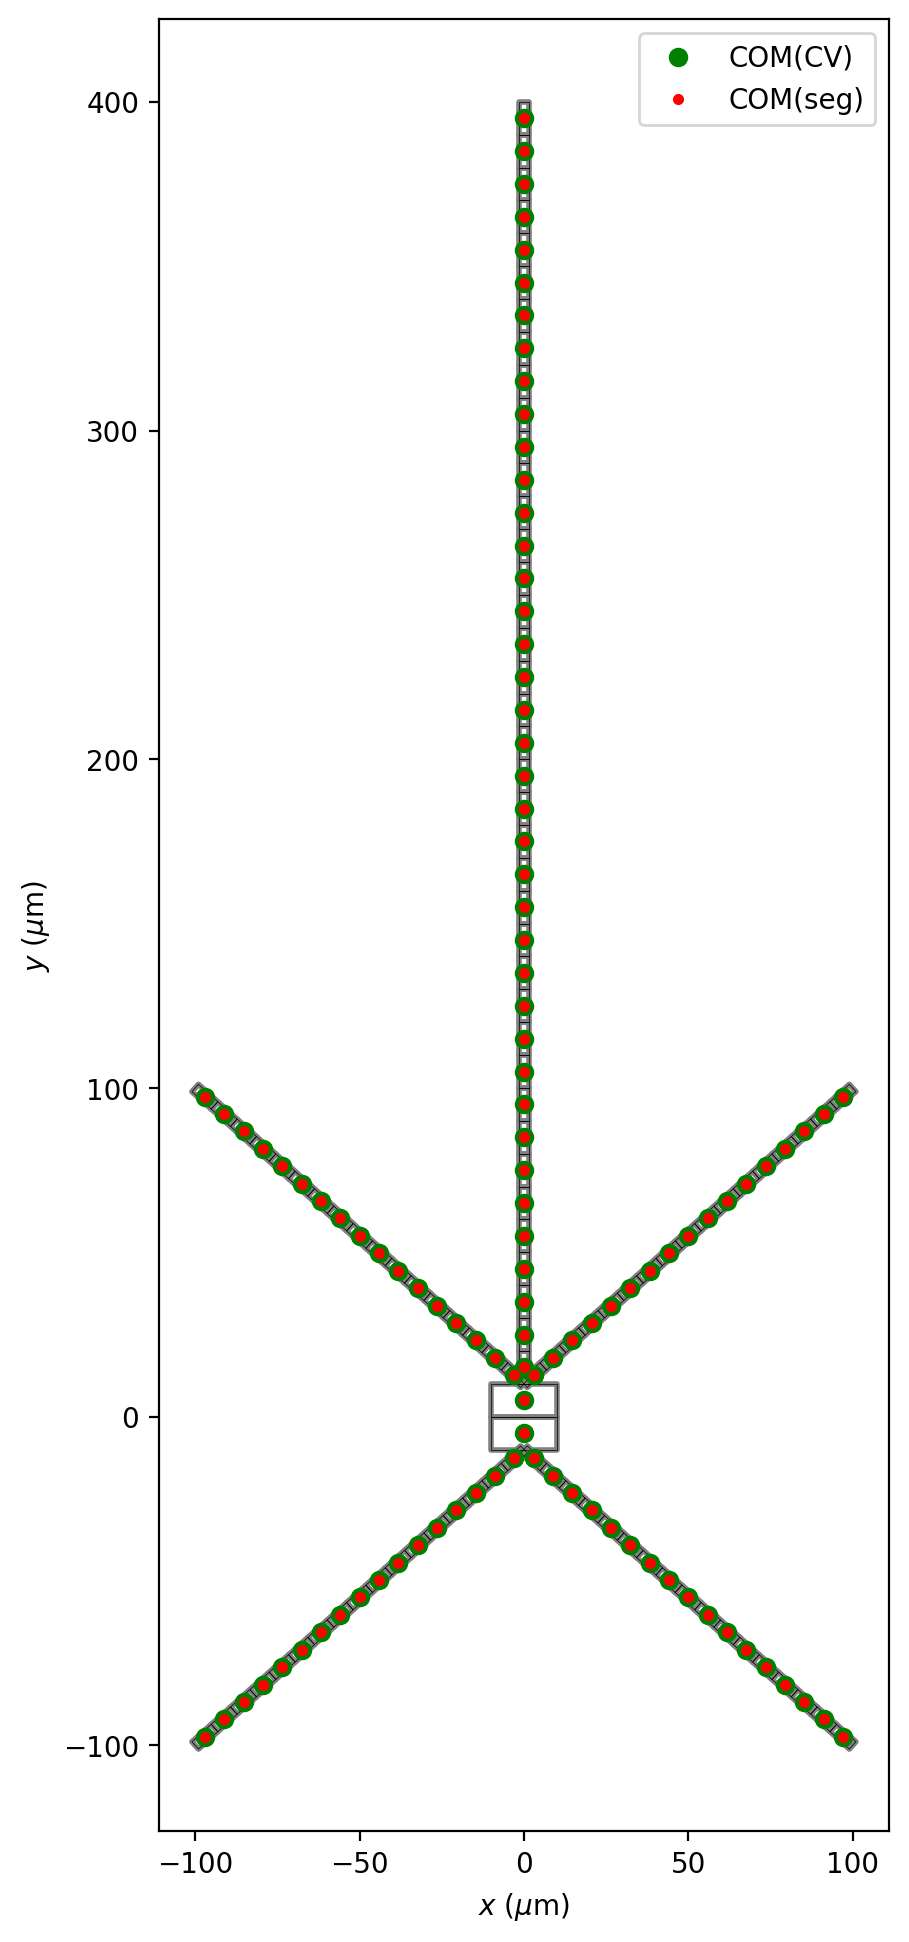

In [22]:
# test morphology plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=200)


# add outline of each CV
zips = []
for i in range(len(loc_sets)):
    inds = CV_ind == i
    zips.append(create_polygon(x[inds, ], z[inds, ], d[inds, ]))
polycol = PolyCollection(zips,
                         edgecolors='gray',
                         facecolors='none',
                         linewidths=2, label='_nolabel_')    
ax.add_collection(polycol)


# outline of segments making up each CV:
if True:
    zips = []
    for x_, z_, d_ in zip(x, z, d):
        zips.append(create_polygon(x_, z_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.25, label='_nolabel_')
    ax.add_collection(polycol)

# plot COM of each CV (sanity test)
ax.plot(r_bar[:, 0], r_bar[:, 2], 'go', label='COM(CV)')

# plot COM of each segment (sanity test)
ax.plot(r_bar_seg[:, 0], r_bar_seg[:, 2], 'r.', label='COM(seg)')
    
    
ax.set_xlabel(r'$x$ ($\mu$m)')
ax.set_ylabel(r'$y$ ($\mu$m)')
ax.set_aspect('equal')
ax.legend()

In [23]:
# draw locsets accd to y-position weighted by area and some function of y
def get_rand_idx_area_and_distribution_norm(areas, 
                                            depth,
                                            n_syn=1,
                                            fun=[st.norm], 
                                            funargs=[dict(loc=200, scale=50)], 
                                            funweights=[1.]):
    '''Return n_syn CV indices with random probability normalized by membrane area
    multiplied with the value of probability density function constructed as
    weigthed sum of `scipy.stats._continuous_dists` function instances
    
    Parameters
    ----------
    areas: 1D ndarray
        Area of each CV
    depth: 1D ndarray
        depth of each CV
    n_syn: int
        number of random indices
    fun: iterable of scipy.stats._continuous_distns.*_gen
        iterable of callable methods in scipy.stats module
    funargs: iterable of dicts
        keyword arguments to each element in `fun`
    funweights: list of floats
        scaling
        
    Returns
    -------
    ndarray
        random indices of size `n_syn` that can be 
    '''
    # probabilities for connecting to CV 
    p = areas.copy()
    mod = np.zeros(areas.size)
    for f, args, w in zip(fun, funargs, funweights):
        df = f(**args)
        mod += df.pdf(x=depth) * w

    # multiply probs by spatial weighting factor
    p *= mod
    # normalize
    p /= p.sum()
    # find CV inds
    return alias_method(np.arange(areas.size), p, n_syn)

(array([ 2.,  4.,  3., 10., 18., 20., 22., 11.,  8.,  2.]),
 array([ 39.11764706,  66.70588235,  94.29411765, 121.88235294,
        149.47058824, 177.05882353, 204.64705882, 232.23529412,
        259.82352941, 287.41176471, 315.        ]),
 <BarContainer object of 10 artists>)

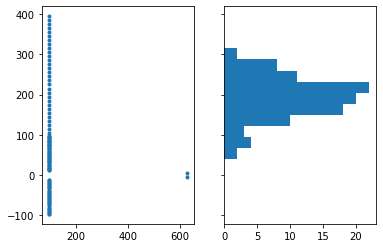

In [24]:
# sanity check
inds = get_rand_idx_area_and_distribution_norm(areas, r_bar[:, 2], n_syn=100, 
                                               fun=[st.norm], 
                                               funargs=[dict(loc=200, scale=50)], 
                                               funweights=[1.])

fig, axes = plt.subplots(1, 2, sharey=True)
# areas per depth
axes[0].plot(areas, r_bar[:, 2], '.')
# num. synapses hist. across depth
axes[1].hist(r_bar[inds][:, 2], orientation='horizontal')

### Proper cell simulation using cell instrumented with synapses distributed accd. to CV area and depth

In [25]:
# randomly chosen loc_sets
inds = get_rand_idx_area_and_distribution_norm(areas, r_bar[:, 2], n_syn=n_syn)
random_loc_sets = np.array(loc_sets)[inds]

# create synapses at each loc_set
for i, loc_set in enumerate(random_loc_sets):
    decor.place(loc_set, arbor.mechanism(synapse, synapse_params), f'{i}')

# synapse activation times (Poisson like)
times = get_activation_times_from_distribution(
    n_syn, tstart=0, tstop=tfinal, 
    distribution=st.expon, rvs_args=dict(loc=0, scale=20))

# synapse weights
weights = st.norm.rvs(size=n_syn, **weight_params)
    
# number of CVs per branch
policy = arbor.cv_policy_max_extent(max_cv_length)
decor.discretization(policy)

# create cell and set properties
cell = arbor.cable_cell(morphology, labels, decor)

# instantiate recipe with cell
recipe = Recipe(cell, weights=weights, times=times)

# instantiate simulation
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

# set up sampling on probes
schedule = arbor.regular_schedule(0.1)
v_handle = sim.sample(recipe.vprobe_id, schedule, arbor.sampling_policy.exact)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)
c_handle = sim.sample(recipe.cprobe_id, schedule, arbor.sampling_policy.exact)

# run simulation for 500 ms of simulated activity and collect results.
sim.run(tfinal=tfinal)

# extract time, V_m and I_m for each compartment
V_m_samples, V_m_meta = sim.samples(v_handle)[0]
I_m_samples, I_m_meta = sim.samples(i_handle)[0]
I_c_samples, I_c_meta = sim.samples(c_handle)[0]

In [26]:
# drop recorded V_m values and corresponding meta data of 
# zero-sized CVs (branch-point potentials)
inds = np.array([m.dist != m.prox for m in V_m_meta])
V_m_samples = V_m_samples[:, np.r_[True, inds]]
V_m_meta = np.array(V_m_meta)[inds].tolist()

In [27]:
# note: the cables comprising the metadata for each probe
# should be the same, as well as the reported sample times.
assert V_m_meta==I_m_meta
assert (V_m_samples[:, 0]==I_m_samples[:, 0]).all()

# prep recorded data for plotting
time = V_m_samples[:, 0]
V_m = V_m_samples[:, 1:].T
I_m = I_m_samples[:, 1:].T
I_c = I_c_samples[:, 1:].T

In [28]:
###############################################################################
# compute extracellular potential using segment information
###############################################################################
# membrane voltages, transmemrbane current and corresponding times
cell_geometry.V_m = V_m  # mV
cell_geometry.I_m = I_m + I_c  # nA, sum stimulation and transmembrane current to mimic sinusoid synapse
cell_geometry.time = time  # ms

# locations where extracellular potential is predicted 
dx = 1
dz = 1
axis = np.round([x.min()-50, x.max()+50, z.min()-10, z.max()+10])
# axis = np.round(axis)
X, Z = np.meshgrid(np.linspace(axis[0], axis[1], int(np.diff(axis[:2]) // dx) + 1), 
                   np.linspace(axis[2], axis[3], int(np.diff(axis[2:]) // dz) + 1))
Y = np.zeros_like(X)

# LineSourcePotential object, get mapping for all segments per CV
lsp = lfpykit.LineSourcePotential(cell=cell_geometry, 
                                  x=X.flatten(), 
                                  y=Y.flatten(), 
                                  z=Z.flatten())
M_tmp = lsp.get_transformation_matrix()

# Define response matrix from M with columns weighted by area of each frusta
M = np.zeros((lsp.x.size, I_m.shape[0]))
for i in range(I_m.shape[0]):
    inds = CV_ind == i
    M[:, i] = M_tmp[:, inds] @ (cell_geometry.area[inds] / cell_geometry.area[inds].sum())

# Extracellular potential using segment information at last time step 
# in x,z-plane coordinates   
V_e = M @ cell_geometry.I_m[:, -1]

## Plotting
Plot the morphology and extracellular potential prediction

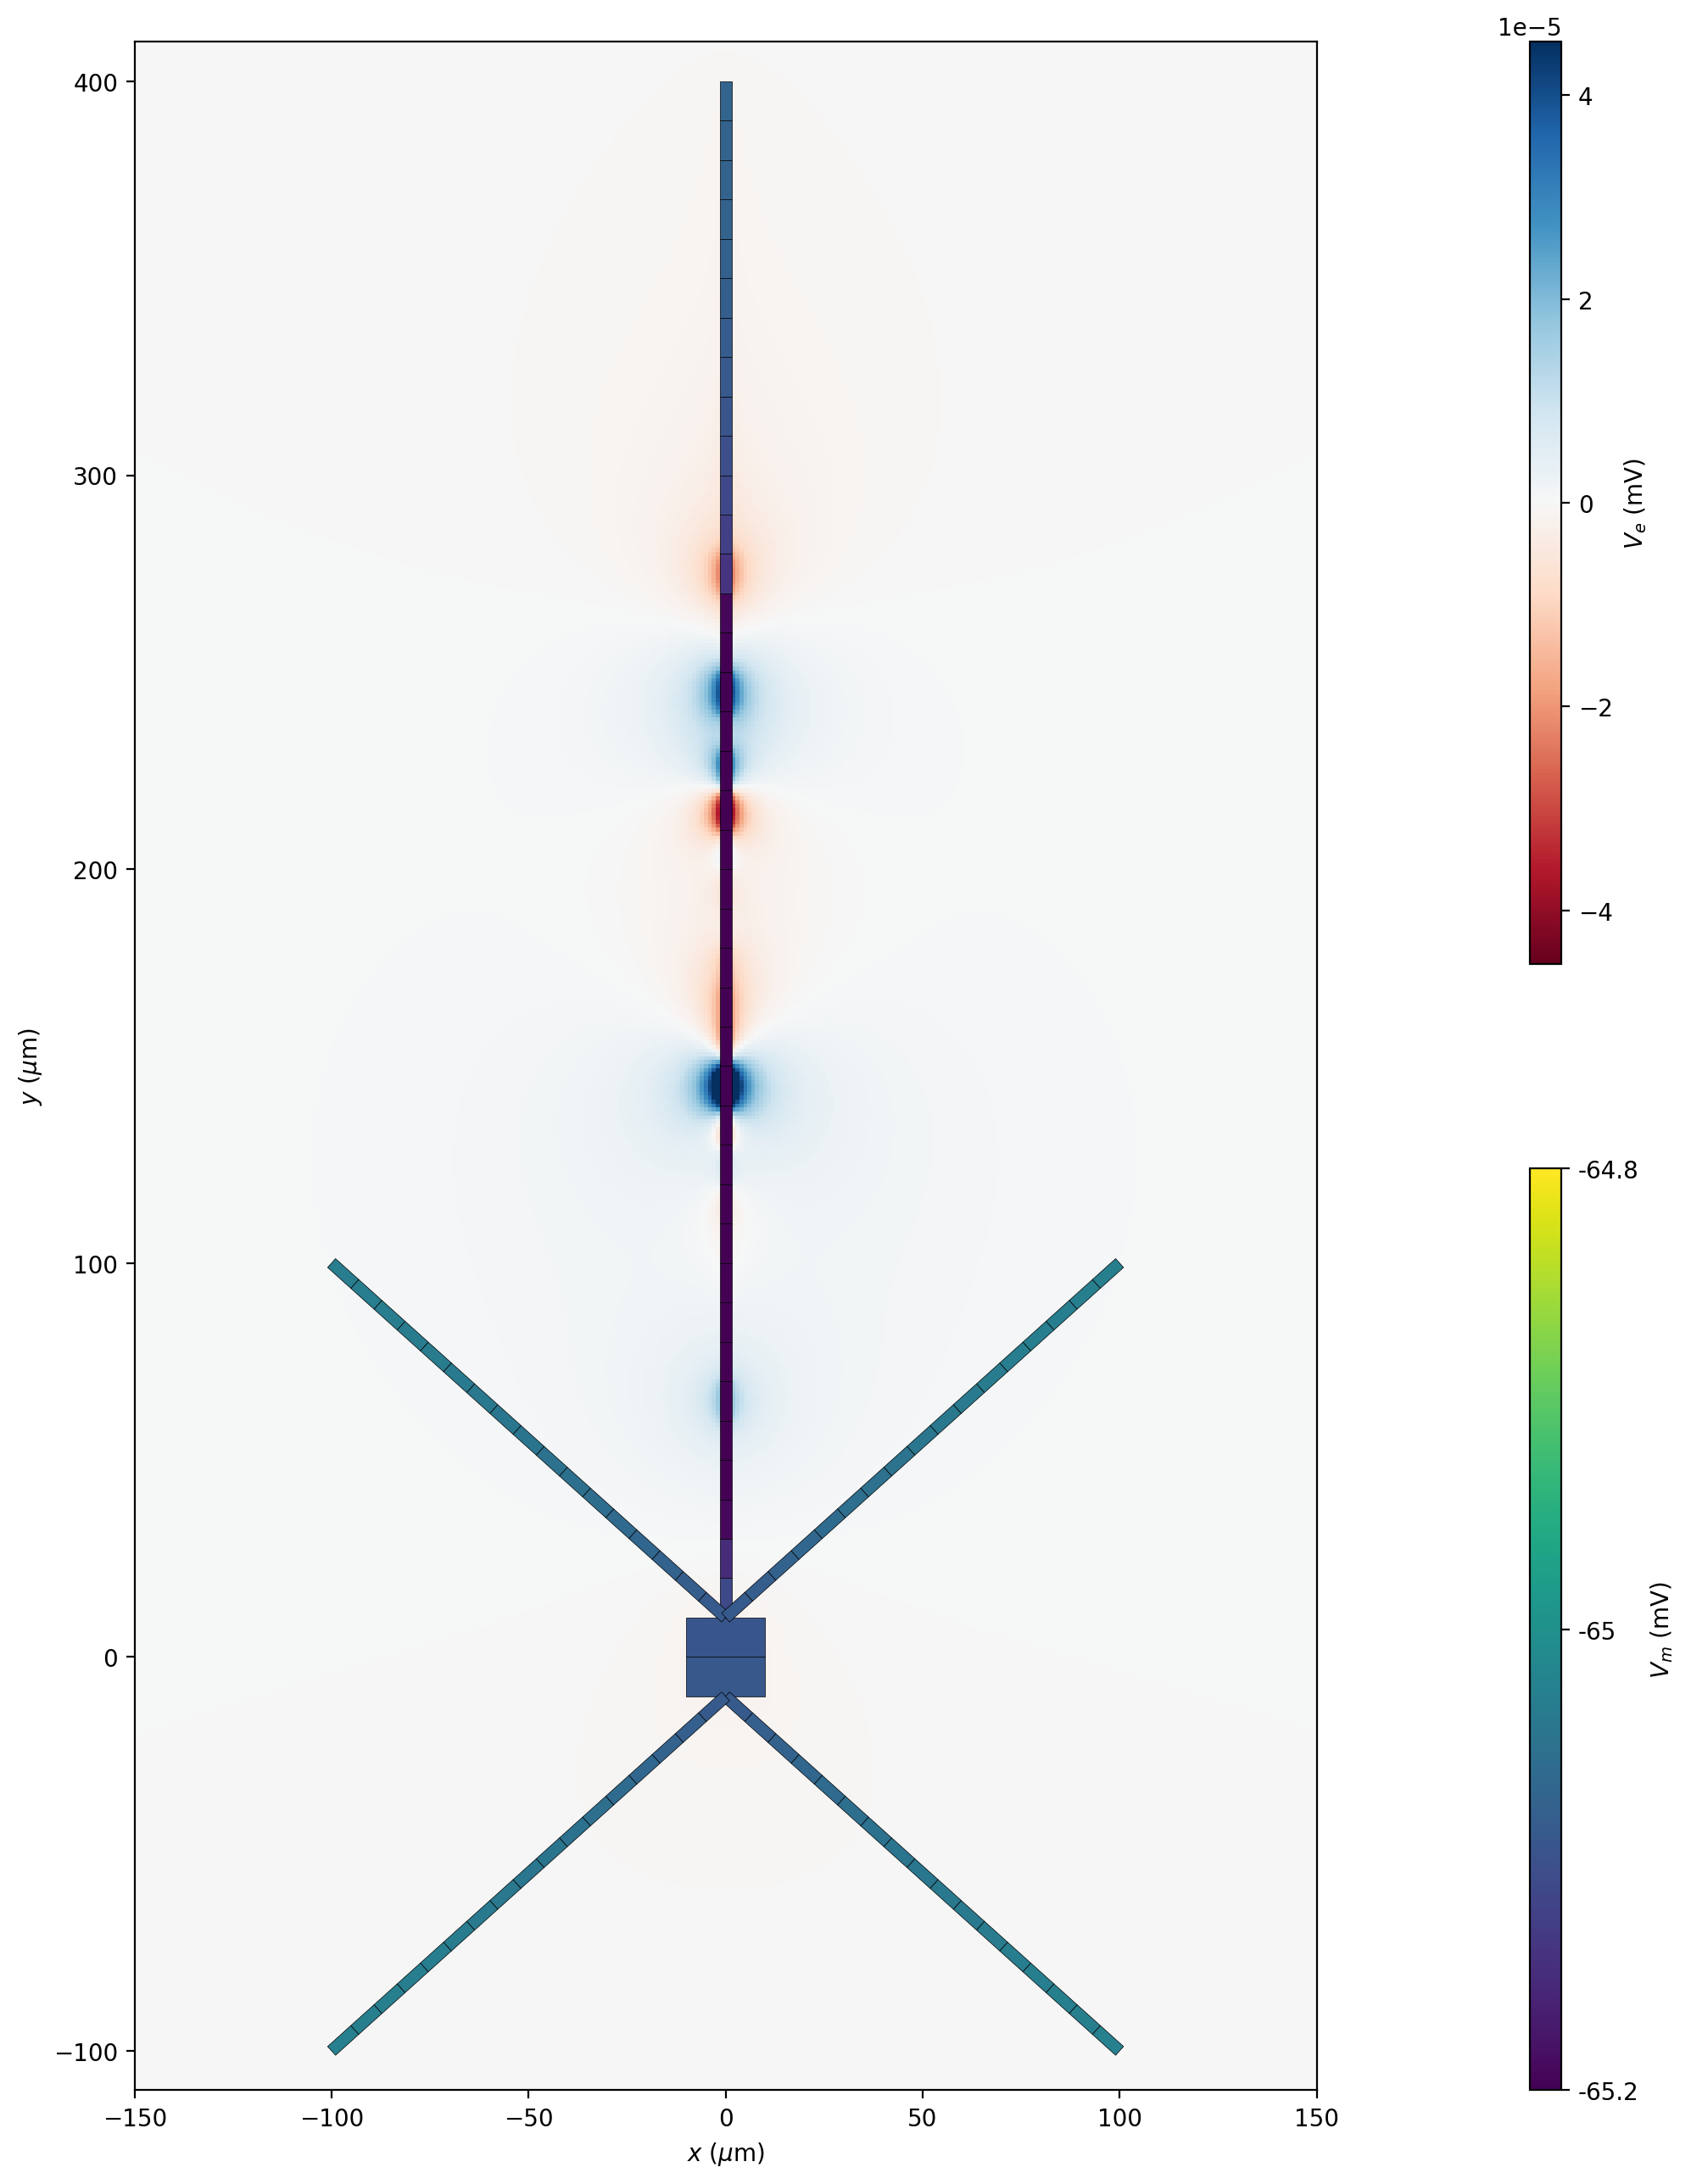

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 16), dpi=200)

# plot pcolormesh plot of V_e
im_V_e = ax.pcolormesh(X, Z, V_e.reshape(X.shape), 
                        shading='auto', cmap='RdBu', 
                        vmin=-abs(V_e).max() / 2, vmax=abs(V_e).max() / 2)
cb = colorbar(fig, ax, im_V_e, height=0.45, voffset=0.55, width=0.02)
cb.set_label('$V_e$ (mV)')


# add outline of each CV
norm = plt.Normalize(vmin=-65.2, vmax=-64.8)
colors = [plt.cm.viridis(norm(v)) for v in cell_geometry.V_m[:, -1]]
zips = []
for i in range(I_m.shape[0]):
    inds = CV_ind == i
    zips.append(create_polygon(x[inds, ], z[inds, ], d[inds, ]))
polycol = PolyCollection(zips,
                         edgecolors='k',
                         facecolors=colors,
                         linewidths=0.25)    
im_V_m = ax.add_collection(polycol)

cb2 = colorbar(fig, ax, im_V_m, height=0.45, width=0.02)
cb2.set_ticks([0, 0.5, 1])
cb2.set_ticklabels([-65.2, -65, -64.8])
cb2.set_label(r'$V_m$ (mV)')

# outline of segments making up each CV:
if False:
    zips = []
    for x_, z_, d_ in zip(x, z, d):
        zips.append(create_polygon(x_, z_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    ax.add_collection(polycol)

    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Z.min(), Z.max())
ax.set_xlabel(r'$x$ ($\mu$m)')
ax.set_ylabel(r'$y$ ($\mu$m)')
ax.set_aspect('equal')

(-0.5, 4999.5, 108.5, -0.5)

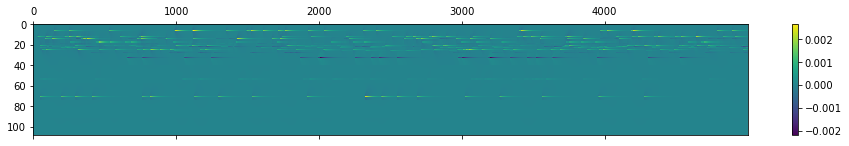

In [30]:
plt.matshow(cell_geometry.I_m)
plt.colorbar()
plt.axis('tight')

(-0.5, 4999.5, 108.5, -0.5)

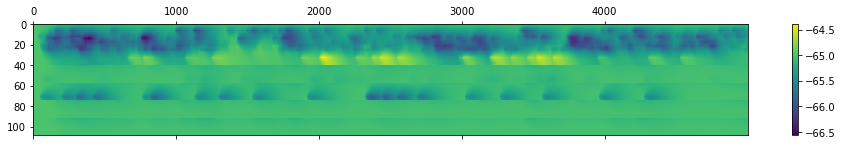

In [31]:
plt.matshow(cell_geometry.V_m)
plt.colorbar()
plt.axis('tight')